<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Model-Load" data-toc-modified-id="Model-Load-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Model Load</a></span></li><li><span><a href="#Data-Load" data-toc-modified-id="Data-Load-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Load</a></span></li><li><span><a href="#Graph-func" data-toc-modified-id="Graph-func-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Graph func</a></span></li><li><span><a href="#MNIST" data-toc-modified-id="MNIST-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>MNIST</a></span></li><li><span><a href="#CIFAR10" data-toc-modified-id="CIFAR10-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>CIFAR10</a></span></li></ul></div>

This notebook will check the results of your assessment of MNIST and CIFAR10 as a pretrained model. So if you don't have a pretrained model, you'll have to run it through the command below and then create a pretrained model first.

```
> python main.py
```

In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dset

import numpy as np
import sys
import os 
import json
sys.path.append('../code')

from dataload import mnist_load, cifar10_load
from model import SimpleCNN

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model Load

In [3]:
# mnist
mnist_simplecnn = torch.load('../checkpoint/simple_cnn_mnist.pth')
mnist_model = SimpleCNN('mnist')
mnist_model.load_state_dict(mnist_simplecnn['model'])

# cifar10
cifar10_simplecnn = torch.load('../checkpoint/simple_cnn_cifar10.pth')
cifar10_model = SimpleCNN('cifar10')
cifar10_model.load_state_dict(cifar10_simplecnn['model'])

Model Complete
Model Complete


<All keys matched successfully>

In [4]:
# Logs load
with open('../logs/simple_cnn_mnist_logs.txt','r') as file:
    mnist_simplecnn_logs = json.load(file)
with open('../logs/simple_cnn_cifar10_logs.txt','r') as file:
    cifar10_simplecnn_logs = json.load(file)

# Data Load

**MNIST**

In [20]:
_, _, mnist_testloader = mnist_load(shuffle=False)
# idx2class
mnist_class2idx = mnist_testloader.dataset.class_to_idx
mnist_idx2class = dict(zip(list(mnist_class2idx.values()), list(mnist_class2idx.keys())))
mnist_idx2class

Data Complete


{0: '0 - zero',
 1: '1 - one',
 2: '2 - two',
 3: '3 - three',
 4: '4 - four',
 5: '5 - five',
 6: '6 - six',
 7: '7 - seven',
 8: '8 - eight',
 9: '9 - nine'}

**CIFAR10**

In [21]:
_, _, cifar10_testloader = cifar10_load(shuffle=False)
# idx2class
cifar10_class2idx = cifar10_testloader.dataset.class_to_idx
cifar10_idx2class = dict(zip(list(cifar10_class2idx.values()), list(cifar10_class2idx.keys())))
cifar10_idx2class

Files already downloaded and verified
Files already downloaded and verified
Data Complete


{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

# Graph func

In [22]:
def loss_acc_plot(train, valid, width, height, title):
    plt.figure(figsize=(width, height))
    ax = sns.lineplot(x=np.arange(len(train['acc'])), y=train['acc'], label='Train Acc')
    sns.lineplot(x=np.arange(len(valid['acc'])), y=valid['acc'], label='Valid Acc', ax=ax)
    ax_2 = ax.twinx()
    sns.lineplot(x=np.arange(len(train['loss'])), y=train['loss'], label='Train Loss', ax=ax_2)
    sns.lineplot(x=np.arange(len(valid['loss'])), y=valid['loss'], label='Valid Loss', ax=ax_2)
    plt.title(title, size=15)
    plt.legend()
    plt.show()

In [23]:
def acc_by_class(model, data, true, idx2class, device):
    # ture type must be numpy array
    indices_by_idx = dict((idx, np.where(true==idx)) for idx in range(10))
    
    # test
    model.to(device)
    model.eval()
    pred_lst = []
    with torch.no_grad():
        for inputs, targets in data:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).detach()
            
            _, predicted = outputs.max(1)
            pred_lst.extend(predicted.cpu().numpy())
    
    pred = np.array(pred_lst)
    
    for idx in range(10):
        indices = indices_by_idx[idx]
        true_idx = true[indices]
        pred_idx = pred[indices]
        correct = np.sum(true_idx == pred_idx)
        acc_idx = correct / true_idx.size
        
        print("Class [{0:10s}] accuracy : {1:.2%}".format(idx2class[idx], acc_idx))
        
    total_acc = np.sum(true==pred) / true.shape[0]
    print()
    print('Total accuracy: {0:.2%}'.format(total_acc))
    
    return total_acc

# MNIST

In [24]:
total_nb_size = sum(torch.numel(e) for _, e in mnist_simplecnn['model'].items())
print('Number of Model Parameters: ', total_nb_size)
print('Best Accuracy: {:.2%}'.format(mnist_simplecnn['best_acc']))
print('Best Epoch: ',mnist_simplecnn['best_epoch'])

Number of Model Parameters:  1284493
Best Accuracy: 99.42%
Best Epoch:  199


In [25]:
mnist_acc = acc_by_class(mnist_model, mnist_testloader, np.array(mnist_testloader.dataset.targets), mnist_idx2class, device)

Class [0 - zero  ] accuracy : 99.80%
Class [1 - one   ] accuracy : 99.65%
Class [2 - two   ] accuracy : 99.52%
Class [3 - three ] accuracy : 99.80%
Class [4 - four  ] accuracy : 99.59%
Class [5 - five  ] accuracy : 99.22%
Class [6 - six   ] accuracy : 99.27%
Class [7 - seven ] accuracy : 98.93%
Class [8 - eight ] accuracy : 99.69%
Class [9 - nine  ] accuracy : 98.51%

Total accuracy: 99.40%


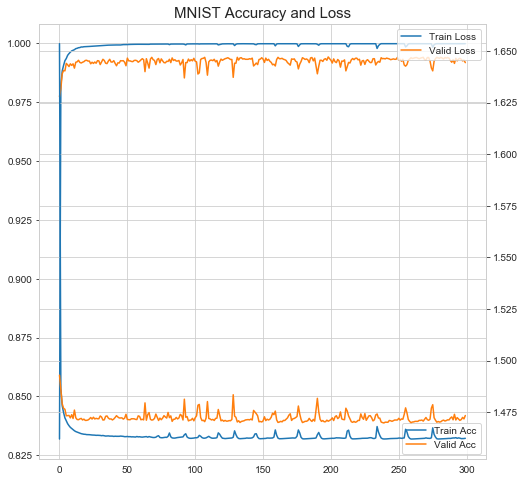

In [12]:
loss_acc_plot(train=mnist_simplecnn_logs['train'][0],
              valid=mnist_simplecnn_logs['validation'][0],
              width=8, height=8,
              title='MNIST Accuracy and Loss')

# CIFAR10

In [26]:
total_nb_size = sum(torch.numel(e) for _, e in cifar10_simplecnn['model'].items())
print('Number of Model Parameters: ', total_nb_size)
print('Best Accuracy: {:.2%}'.format(cifar10_simplecnn['best_acc']))
print('Best Epoch: ',cifar10_simplecnn['best_epoch'])

Number of Model Parameters:  2202573
Best Accuracy: 85.62%
Best Epoch:  271


In [28]:
cifar10_acc = acc_by_class(cifar10_model, cifar10_testloader, np.array(cifar10_testloader.dataset.targets), cifar10_idx2class, device)

Class [airplane  ] accuracy : 88.40%
Class [automobile] accuracy : 93.10%
Class [bird      ] accuracy : 77.30%
Class [cat       ] accuracy : 65.30%
Class [deer      ] accuracy : 87.50%
Class [dog       ] accuracy : 82.80%
Class [frog      ] accuracy : 90.20%
Class [horse     ] accuracy : 85.50%
Class [ship      ] accuracy : 92.00%
Class [truck     ] accuracy : 90.40%

Total accuracy: 85.25%


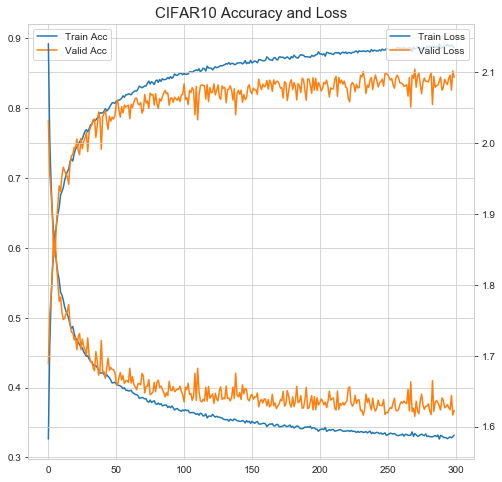

In [29]:
loss_acc_plot(train=cifar10_simplecnn_logs['train'][0],
              valid=cifar10_simplecnn_logs['validation'][0],
              width=8, height=8,
              title='CIFAR10 Accuracy and Loss')